# Предсказание активности ингибиторов тирозин-протеинкиназы JAK3 с помощью методов машинного обучения

В данном проекте с помощью методов машинного обучения предсказывается ингибирующая активность малых молекул по отношению к тирозин-протеинкиназе JAK3, являющейся одной из ключевых фармацевтических мишеней для лечения иммуноопосредованных и воспалительных заболеваний, таких как псориатический артрит, анкилозирующий спондилоартрит, язвенный колит, ювенильный идиопатический артрит и других [1].

В проекте применяется датасет, полученный из базы данных PubChem [2].




1. Castelo-Soccio, L., Kim, H., Gadina, M. et al. Protein kinases: drug targets for immunological disorders. Nat Rev Immunol 23, 787–806 (2023). https://doi.org/10.1038/s41577-023-00877-7
2. National Center for Biotechnology Information (2024). PubChem Protein Summary for Protein P52333, Tyrosine-protein kinase JAK3 (human). Retrieved June 21, 2024 from https://pubchem.ncbi.nlm.nih.gov/protein/P52333.

## Часть 1. Подготовка начального датасета
В датасете jak3.csv, полученном из базы данных PubChem, содержится много лишней информации. В данной части все ненужные столбцы удаляются, остается только 2 - cid (Chemical Identifier) малых молекул для дальнейшего получения дескрипторов, а также целевая характеристика - активность малых молекул, в данном случае представленная концентрацией в µM (10^(-6) моль/л)

In [3]:
import pandas as pd

In [4]:
# Загрузка сырого датасета
df_raw = pd.read_csv('jak3.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17119 entries, 0 to 17118
Data columns (total 27 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0    baid        17119 non-null  int64  
 1   activity     17119 non-null  object 
 2   aid          17119 non-null  int64  
 3   sid          17119 non-null  int64  
 4   cid          17117 non-null  float64
 5   geneid       17119 non-null  int64  
 6   pmid         4971 non-null   float64
 7   aidtype      17119 non-null  object 
 8   aidmdate     17119 non-null  int64  
 9   hasdrc       17119 non-null  int64  
 10  rnai         17119 non-null  int64  
 11  protacxn     17119 non-null  object 
 12  acname       14777 non-null  object 
 13  acqualifier  6294 non-null   object 
 14  acvalue      14653 non-null  float64
 15  aidsrcname   17119 non-null  object 
 16  aidname      17119 non-null  object 
 17  cmpdname     17109 non-null  object 
 18  targetname   17119 non-null  object 
 19  targ

In [5]:
# Отбор значимой информации из сырого датасета
df_init = df_raw.copy()
df_init = df_init[['cid', 'acvalue']]
df_init.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17119 entries, 0 to 17118
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   cid      17117 non-null  float64
 1   acvalue  14653 non-null  float64
dtypes: float64(2)
memory usage: 267.6 KB


In [6]:
# Удаление пропущенных значений
df_init.dropna(how='any', inplace = True)
df_init.reset_index(drop=True, inplace=True)

df_init['cid'] = df_init['cid'].astype(int).astype(str)
df_init.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14653 entries, 0 to 14652
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   cid      14653 non-null  object 
 1   acvalue  14653 non-null  float64
dtypes: float64(1), object(1)
memory usage: 229.1+ KB


In [7]:
# Удаление дубликатов
df_init.drop_duplicates(subset=['cid'], inplace=True)
df_init.reset_index(drop=True, inplace=True)

df_init = df_init.rename(columns={'acvalue': 'target'})
df_init.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9563 entries, 0 to 9562
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   cid     9563 non-null   object 
 1   target  9563 non-null   float64
dtypes: float64(1), object(1)
memory usage: 149.5+ KB


## Часть 2. Получение дескрипторов

В данном разделе с помощью популярных химических библиотек (rdkit, pubchempy) будут получены дескрипторы малых молекул.

In [8]:
!pip install rdkit>None
!pip install pubchempy>None

In [9]:
import pubchempy as pcp
import numpy as np
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors

In [10]:
# Функция для получения SMILES по CID
def get_smiles(cid):
    try:
        compound = pcp.Compound.from_cid(cid)
        return compound.canonical_smiles
    except:
        return None

# Добавление новой колонки со SMILES в датасет
df_init['smiles'] = df_init['cid'].apply(get_smiles)
df_init.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9563 entries, 0 to 9562
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   cid     9563 non-null   object 
 1   target  9563 non-null   float64
 2   smiles  5682 non-null   object 
dtypes: float64(1), object(2)
memory usage: 224.3+ KB


In [11]:
"""
Как видно из предыдущего блока, не для каждого CID получен SMILES.
Удалим строки с пропущенными занчениями SMILES
"""
df_init.dropna(subset=['smiles'], inplace=True)
df_init.reset_index(drop=True, inplace=True)
df_init.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5682 entries, 0 to 5681
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   cid     5682 non-null   object 
 1   target  5682 non-null   float64
 2   smiles  5682 non-null   object 
dtypes: float64(1), object(2)
memory usage: 133.3+ KB


In [12]:
def get_rdkit(df):
  # Получение списка доступных дескрипторов
  descriptor_names = list(rdMolDescriptors.Properties.GetAvailableProperties())
  get_descriptors = rdMolDescriptors.Properties(descriptor_names)
  num_descriptors = len(descriptor_names)

  # Инициализация пустой матрицы для дескрипторов
  descriptors_set = np.empty((0, num_descriptors), float)

  # Расчет дескрипторов
  for _, row in df.iterrows():
      smiles = row['smiles']
      molecule = Chem.MolFromSmiles(smiles)


      if molecule is not None:
          descriptor = np.array(get_descriptors.ComputeProperties(molecule)).reshape((-1, num_descriptors))
          descriptors_set = np.append(descriptors_set, descriptor, axis=0)

  # Создание DataFrame с дескрипторами
  df_descriptors = pd.DataFrame(descriptors_set, columns=descriptor_names)

  # Объединение существующего датасета с новыми дескрипторами
  df_rdkit = pd.concat([df, df_descriptors], axis=1)

  return df_rdkit

df_rdkit = get_rdkit(df_init)
df_rdkit.head()

,cid,target,smiles,exactmw,amw,lipinskiHBA,lipinskiHBD,NumRotatableBonds,NumHBD,NumHBA,...,chi0n,chi1n,chi2n,chi3n,chi4n,hallKierAlpha,kappa1,kappa2,kappa3,Phi
0,5329102,1.2000,CCN(CC)CCNC(=O)C1=C(NC(=C1C)C=C2C3=C(C=CC(=C3)...,398.211804,398.482,6.0,3.0,7.0,3.0,3.0,...,17.279503,9.879065,5.364539,5.364539,3.662779,-2.93,20.795285,8.611070,4.244127,6.174815
1,9926791,0.0022,CC1CCN(CC1N(C)C2=NC=NC3=C2C=CN3)C(=O)CC#N,312.169859,312.377,7.0,1.0,3.0,1.0,5.0,...,13.359495,7.771394,4.666128,4.666128,3.255870,-2.62,15.282400,6.244406,2.842656,4.149109
2,24202429,0.0120,CC12C(C(CC(O1)N3C4=CC=CC=C4C5=C6C(=C7C8=CC=CC=...,570.226705,570.649,8.0,1.0,3.0,1.0,6.0,...,24.126452,14.758273,10.035579,10.035579,8.327087,-4.66,24.893656,8.461354,2.968438,4.898466
3,156414,0.6300,C=CC(=O)NC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC(=C(C=C...,485.162996,485.947,8.0,2.0,9.0,2.0,7.0,...,18.520621,10.904191,5.342228,5.342228,3.590039,-3.27,23.873698,11.237627,5.990027,7.890697
4,10138259,0.5800,CC1=C(NC(=C1C(=O)NCC(CN2CCOCC2)O)C)C=C3C4=C(C=...,442.201634,442.491,8.0,4.0,6.0,4.0,5.0,...,18.126529,10.616897,5.827421,5.827421,4.152240,-3.01,22.193486,9.234168,4.594859,6.404325


In [ ]:
df_rdkit.info()

## Часть 3. Отбор признаков

В данной части будет проведен отбор признаков по коэффициенту корреляции, нормализация и снижение размерности данных

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [15]:
# Удаление столбца cid
df_rdkit.drop('cid', axis=1, inplace=True)

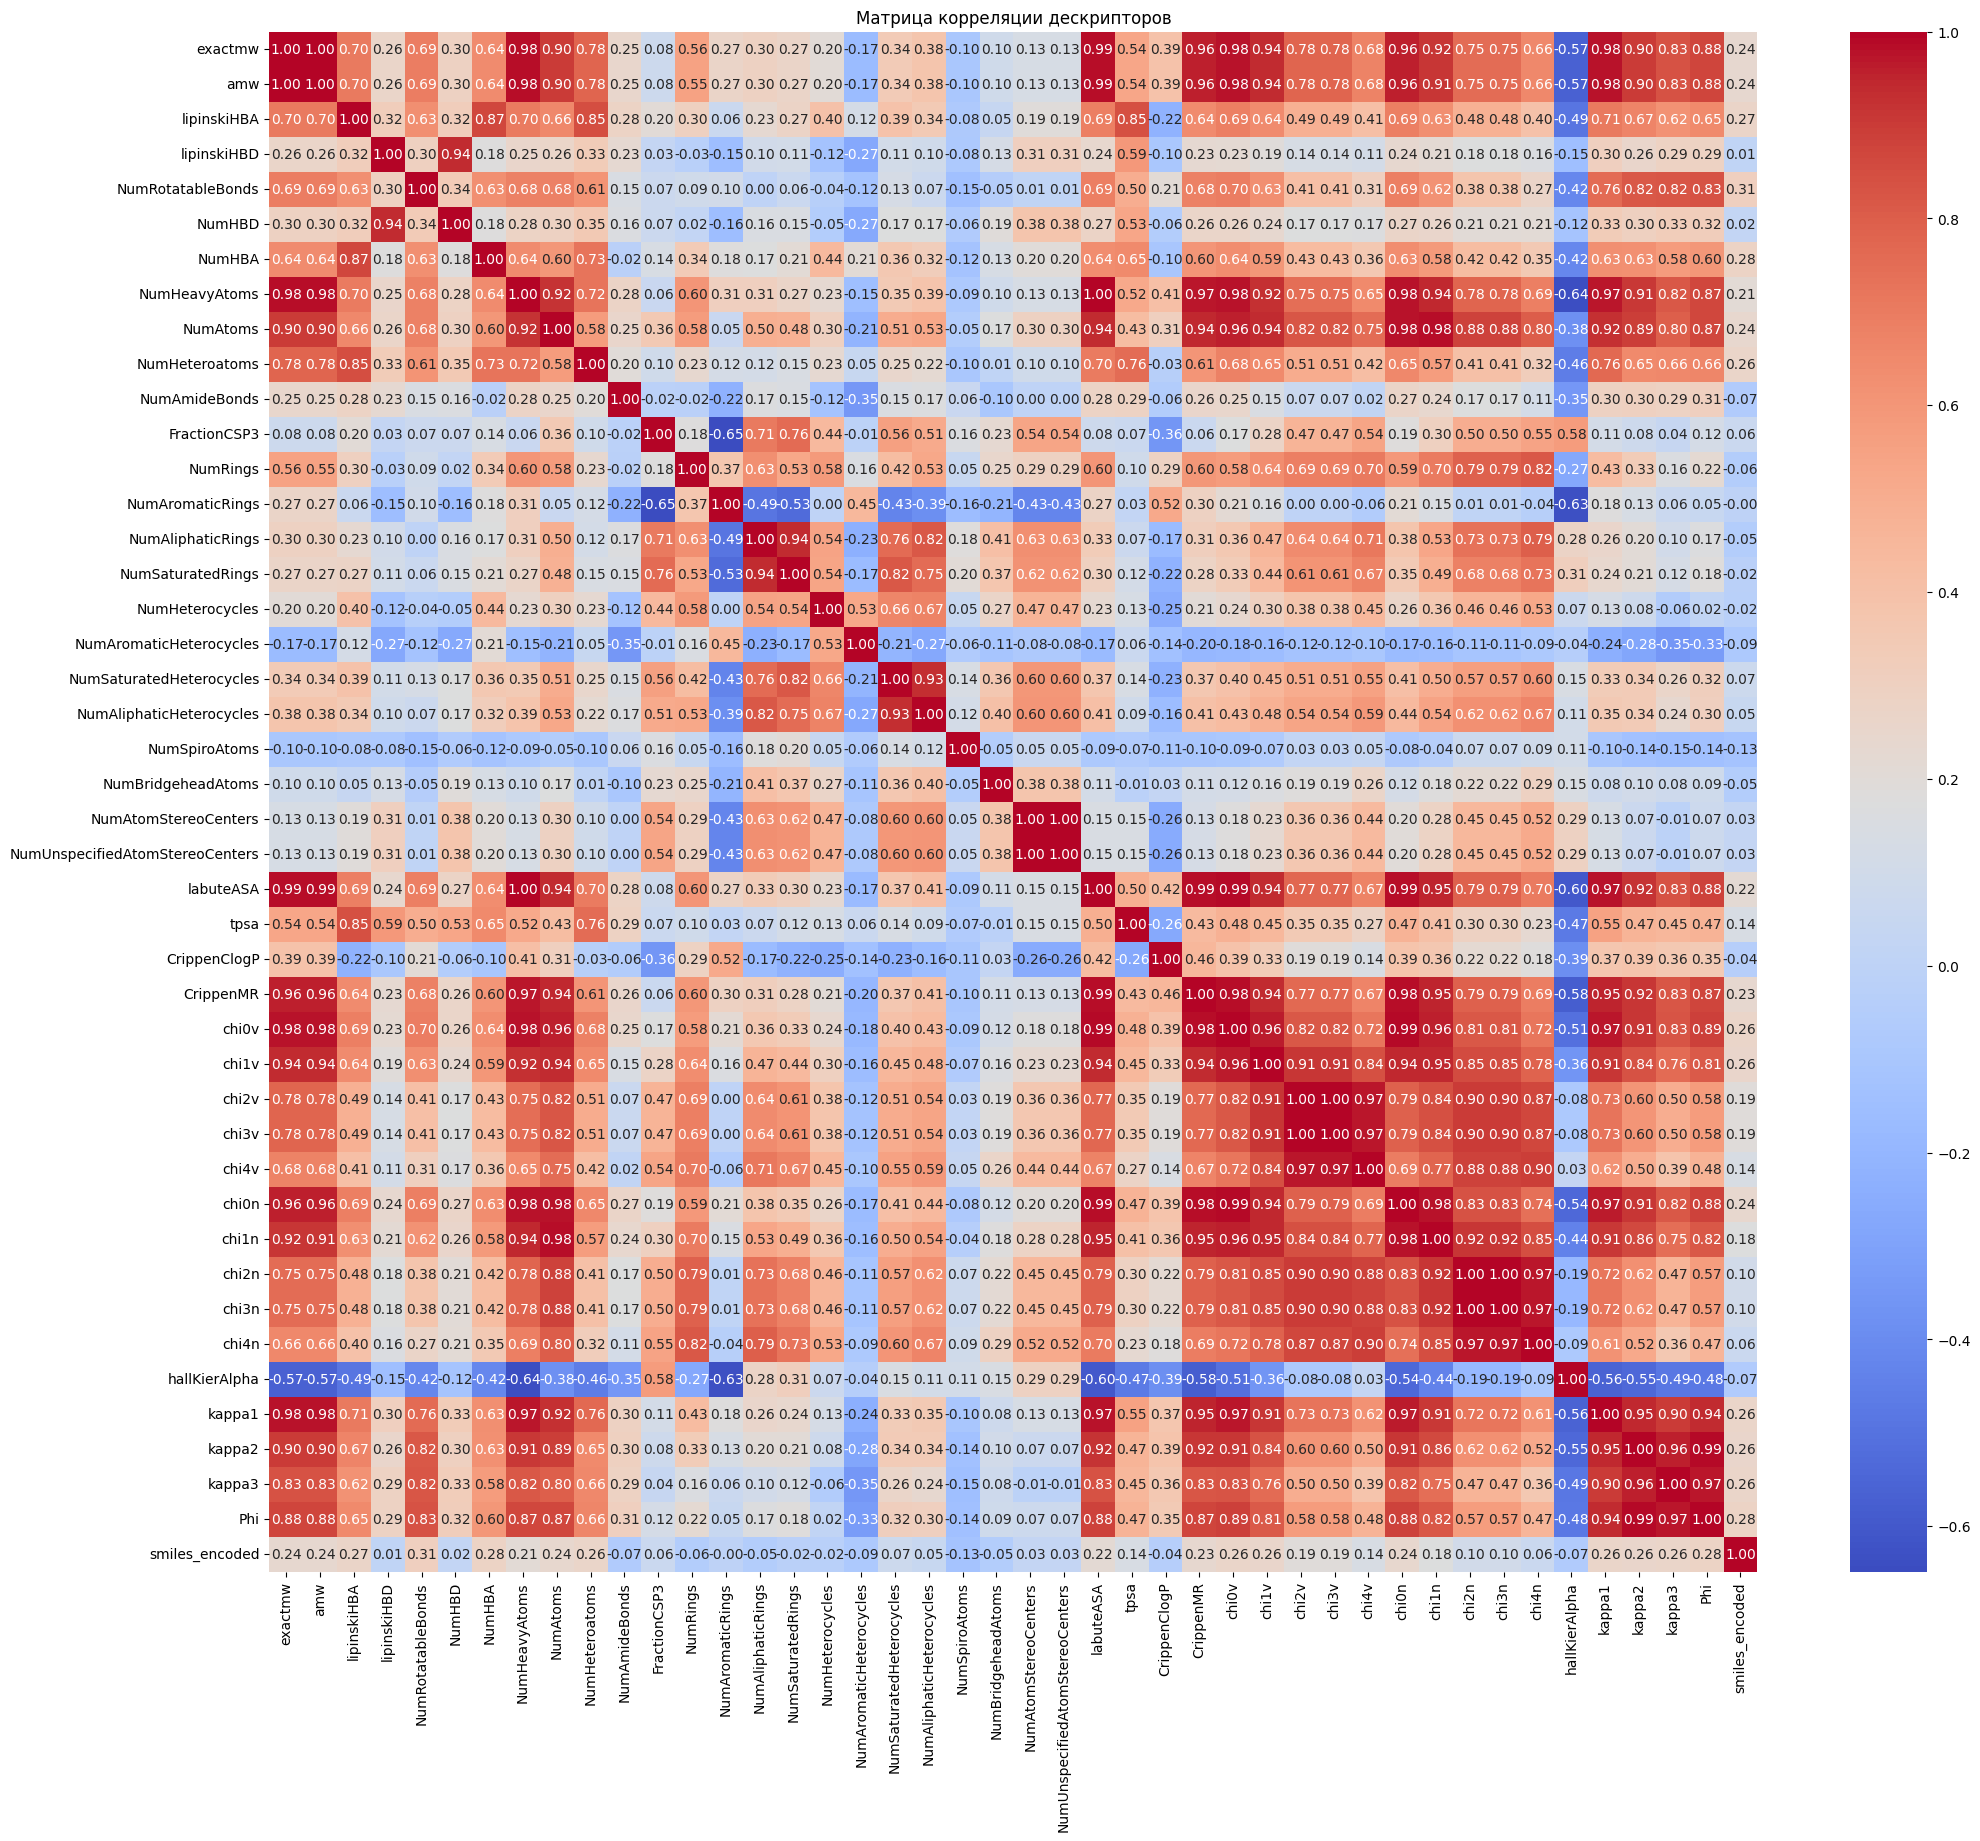

In [16]:
# Кодирование столбца smiles
le = LabelEncoder()
df_rdkit['smiles_encoded'] = le.fit_transform(df_rdkit['smiles'])
df_rdkit.drop('smiles', axis=1, inplace=True)

# Визуализация матрицы корреляции
df_corr = df_rdkit.drop('target', axis=1)
corr_matrix = df_corr.corr()
plt.figure(figsize=(24, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Матрица корреляции дескрипторов')
plt.show()

In [34]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

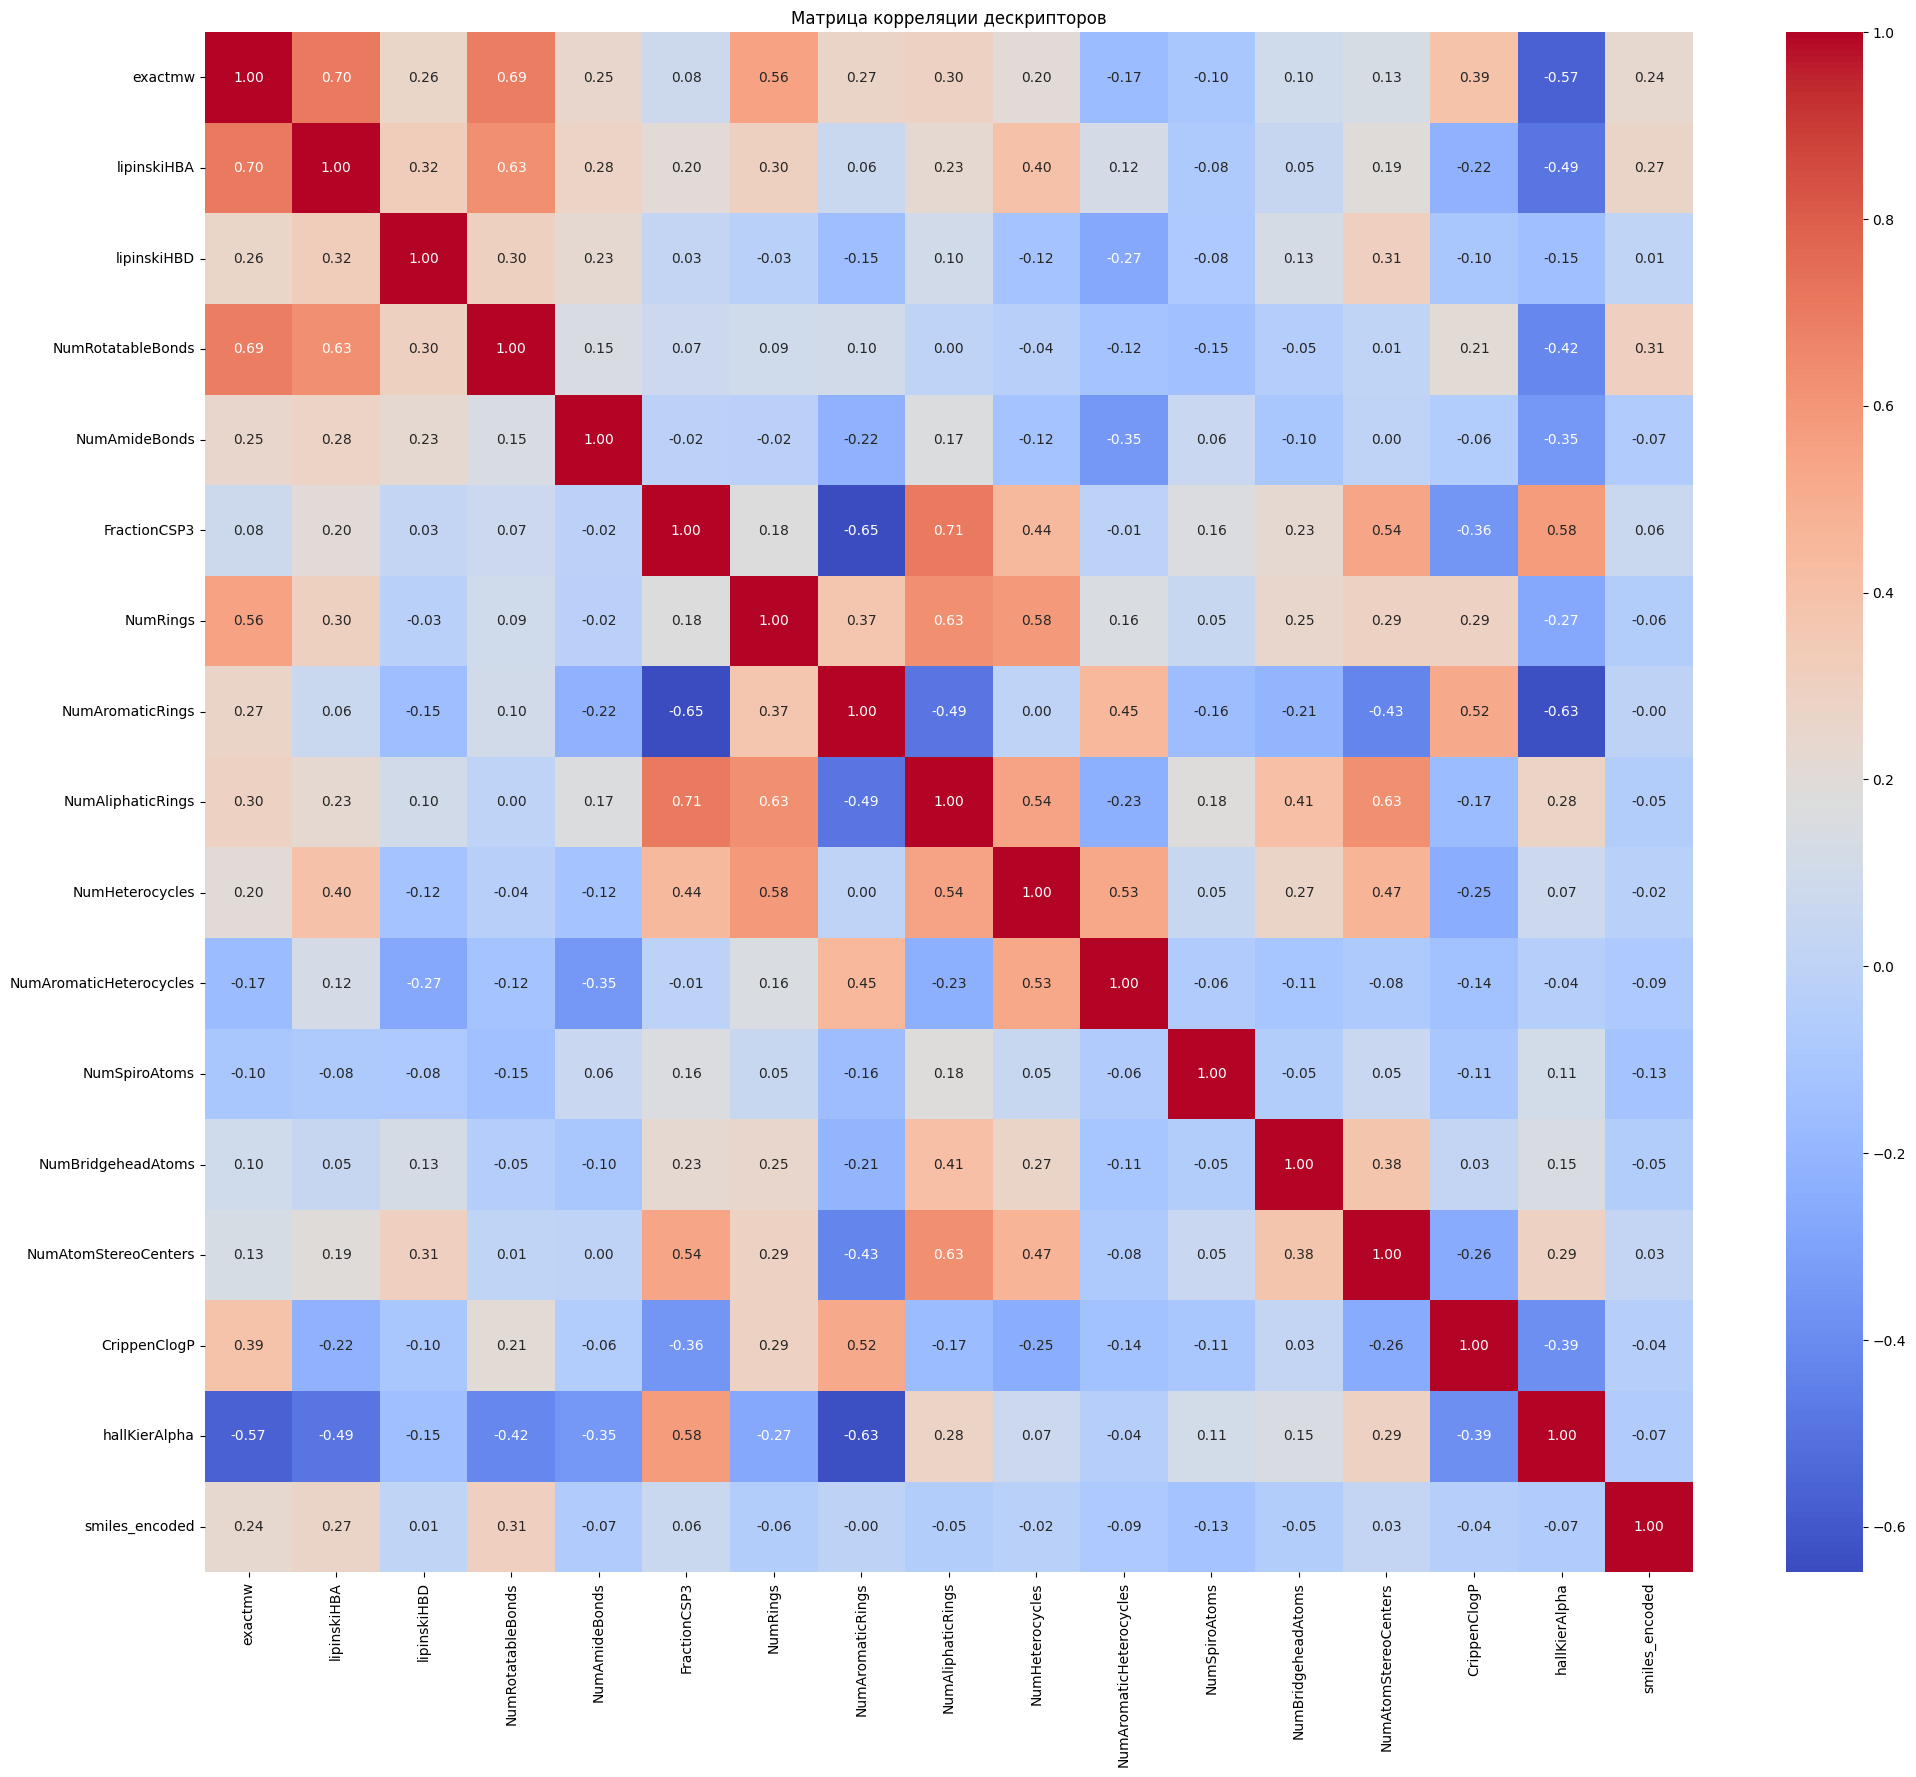

In [18]:
# Удаление дескрипторов с высокой корреляцией
corr_threshold = 0.75
high_corr = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > corr_threshold:
            colname = corr_matrix.columns[i]
            high_corr.add(colname)

df_rdkit_filtered = df_rdkit.drop(high_corr, axis=1)

# Визуализация матрицы корреляции
df_corr = df_rdkit_filtered.drop('target', axis=1)
corr_matrix = df_corr.corr()
plt.figure(figsize=(24, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Матрица корреляции дескрипторов')
plt.show()

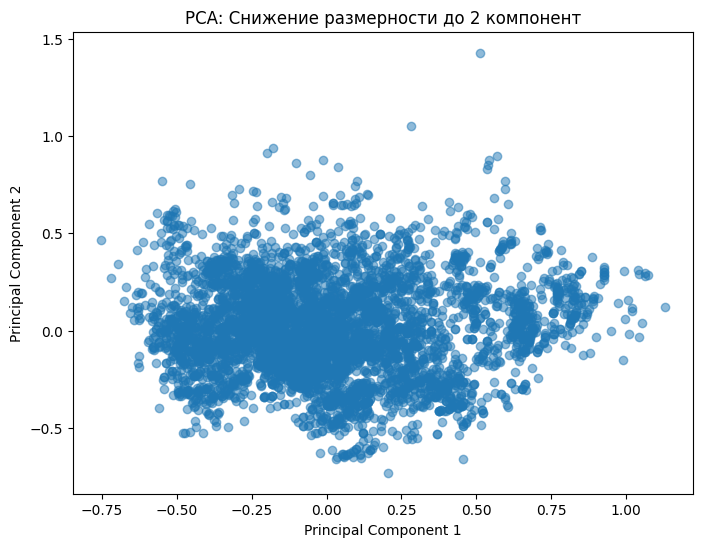

Количество компонент PCA, объясняющих 95% дисперсии: 9


In [35]:
# Нормализация данных
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(df_rdkit_filtered.drop(['target', 'smiles_encoded'], axis=1))

y = np.array(df_rdkit_filtered['target']).reshape(-1, 1)
y = scaler.fit_transform(y)

# Снижение размерности с использованием PCA
pca = PCA()
pca_result = pca.fit_transform(X_normalized)

# Определение количества компонент, объясняющих 95% дисперсии
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
n_components_for_95_variance = np.argmax(cumulative_variance_ratio >= 0.95) + 1

# Визуализация результата снижения размерности
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
plt.title('PCA: Снижение размерности до 2 компонент')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

print(f'Количество компонент PCA, объясняющих 95% дисперсии: {n_components_for_95_variance}')

In [36]:
# Снижение размерности с использованием PCA
pca = PCA(n_components=10)
X = pca.fit_transform(X_normalized)
y = y.reshape(-1)

## Часть 4. Построение модели
Как упоминалось в аннотации, целью проекта является **предсказание активности ингибиторов тирозин-протеинкиназы JAK3**. В предыдущих частях были получены необходимые для обучения модели дескрипторы, целевая характеристика находится в столбце target (напомню, что это концентрация в µM (10^(-6) моль/л)).

В данной части будут построены различные модели машинного обучения, выбрана одна, с наилучшими метриками, для дальнейшей оптимизации гиперпараметров.

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

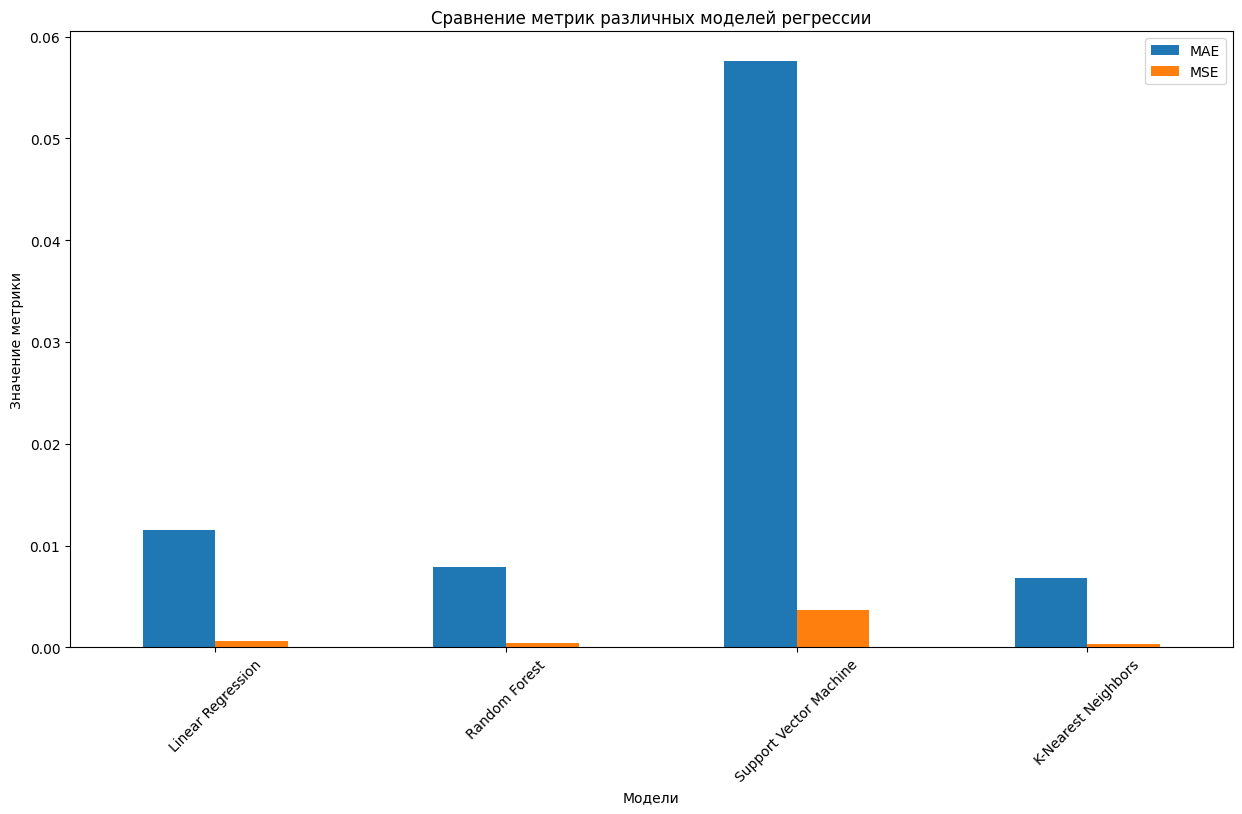

In [39]:
# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2024)

# Создание списка моделей
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'Support Vector Machine': SVR(),
    'K-Nearest Neighbors': KNeighborsRegressor()
}

# Обучение и тестирование моделей
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    results[name] = {'MAE': mae, 'MSE': mse}

# Визуализация метрик
metrics_df = pd.DataFrame(results).T
metrics_df.plot(kind='bar', figsize=(15, 8))
plt.title('Сравнение метрик различных моделей регрессии')
plt.ylabel('Значение метрики')
plt.xlabel('Модели')
plt.xticks(rotation=45)
plt.show()

In [41]:
print(results)

{'Linear Regression': {'MAE': 0.011490910191947838, 'MSE': 0.0006101168265346292}, 'Random Forest': {'MAE': 0.007905762108520365, 'MSE': 0.0003948880829052313}, 'Support Vector Machine': {'MAE': 0.057625524766634954, 'MSE': 0.0037169227549721075}, 'K-Nearest Neighbors': {'MAE': 0.006841807853742248, 'MSE': 0.0003671975861783556}}


Как можно заметить, наименьшая ошибка у модели K-Nearest Neighbors, именно она была выбрана для дальнейшей оптимизации гиперпараметров

In [43]:
# Определение модели RF
knn = KNeighborsRegressor()

# Параметры для поиска по сетке
param_grid = {
    'n_neighbors': [3, 5, 7, 9],  # Подбор оптимального значения k
    'weights': ['uniform', 'distance']  # Использование весов для соседей
}

# Создание объекта Grid Search с кросс-валидацией
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Обучение модели на тренировочных данных
grid_search.fit(X_train, y_train)

# Вывод лучших параметров и оценки модели
print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая оценка:", -grid_search.best_score_)

# Получение предсказаний на тестовых данных
y_pred = grid_search.predict(X_test)

# Вычисление метрик на тестовом наборе данных
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("MSE:", mse)
print("R2:", r2)


Лучшие параметры: {'n_neighbors': 9, 'weights': 'uniform'}
Лучшая оценка: 0.0005217617171093287
MAE: 0.006876657932730831
MSE: 0.0003689927351589521
R2: 0.4069139063313644


In [46]:
y.std()

0.02759754168582002

## Результаты и выводы
В ходе работы была получена модель Random Forest со следующими гипер параметрами:
n_neighbors = 9, weights = 'uniform'.
Данная модель была оценена с помощью тестового набора данных, получены следующие значения метрик: MAE = 0.0069, MSE = 0.00037, R2 = 0.407

Как видно из полученных метрик, оптимизированная модель все еще не способна достаточно хорошо предсказывать ингибирующую активность малых молекул по отношению к тирозинкиназе. Возможно, это связано с недостаточным количеством данных или простотой модели. Вероятно, при использовании методов глубокого обучения метрики получились бы лучше.
Также следует заметить, что в данной работе были использованы довольно общие дескрипторы из библиотеки RDKit, вероятно, более специфичные для данной цели дескрипторы показали бы лучший результат.

Если обратиться к литературным источникам, можно заметить, что задача регрессии для химических данных решается реже, чем задача классификации, что также показывает сложность точного предсказания целевой величины при разнородности данных.

Однако, несмотя на низкое значение метрики R2, можно заметить, что средняя абсолютная ошибка ниже, чем стандартное отклонение в целевой характеристике. Из этого следует, что данная модель может применяться для приблизительной оценки ингибирующей активности малых молекул по отношению к тирозинкиназе JAK3. А это уже может значительно упростить процедуру скрининга соединений, убирая заведомо низкоактивные соединения, и ускорить тем самым процесс разработки фармацевтических препаратов.

